# Encoding Excel data with *libinsitu*

This notebook demonstrates how to encode Excel data to NetCDF data following [in-situ standards](https://libinsitu.readthedocs.io/en/latest/conventions.html).

In this example, we take meteorogical data of [CAR-NASRDA](https://carnasrda.com/) : National Space Research and Development Agency of **Nigeria**

<p style="background-color:yellow">
Cells starting with a "!" are CLI commands (are run from a system shell).
Other cells are Python code.
</p> 

In [2]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# Explore data

Let see what's in this Excel file

In [3]:
df = pd.read_excel("data/abuja-air-2008-08-01.xls", header=None)
df.head(15)

,0,1
0,TOA5,CPU:5MinProg.CR1
1,TIMESTAMP,AirTC_Avg
2,TS,Deg C
3,NaN,Avg
4,NaN,NaN
5,2008-08-01 00:05:00,24.68
6,2008-08-01 00:10:00,24.64
7,2008-08-01 00:15:00,24.59
8,2008-08-01 00:20:00,24.53
9,2008-08-01 00:25:00,24.44


This file contains only timestamp & air temperature.

Column names are in line 2.

Line 1 and 3, 4, 5 should be skipped.

# Prepare config files

The folder [config](./config) contains config files that will be useful for the transformation :

 * **schema.cdl** : A custom NetCDF schema
 * **station.csv** : Station meta data
 * **mapping.json** : A config file for mapping Excel column of the source file to NetCDF variables

## schema.cdl : NetCDF  schema (Common Data Langage)

A CDL schema defines the structure (dimensions), variables and metadata of a NetCDF file. 

`libinsitu` comes with an embedded default [NetCDF Shema (CDL file)](https://git.sophia.mines-paristech.fr/oie/libinsitu/-/blob/main/libinsitu/res/base.cdl?ref_type=heads). It is well suited or solar irradiance data but not so much for our example. We can (and will) use a custom schema for this example.

This schema should respect our [proposed convention](https://libinsitu.readthedocs.io/en/latest/conventions.html). in particular :
* The meta data in this schema should be organized following [CF conventions](http://cfconventions.org/).
* There should be a unique time dimension, expressed as seconds since epoch, in UTC
* Variables names should be searched in [CF standard names](http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html) and named accordingly.
* Global attributes should follow [ACDD](https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3) (Attribute Convention for Data Discovery)

For each station, the placeholders `{Station_<Param>}` will be replaced by the values found in `stations.csv`

In [4]:
# Here is the content of our custom schema :
# It contains a some variables with no dimensions (station_name, latitude, longitude, elevation)
# It has a unique dimension 'time' and two varaibles along it : 
# The time itself (as seconds since epoch) and the temprature (in kelvin)

!cat data/config/schema.cdl

netcdf base {

    dimensions:
        time = UNLIMITED ; # Main dimension

    variables:

        # --------------------------------------
        # Static scalar values
        # --------------------------------------

        # Station name, filled from metadata
        string station_name;
            *:standard_name = "platform_name" ;
            *:long_name = "station_name" ;
            *:cf_role = "timeseries_id" ;
            *:_value = {!Station_ID};

        # Latitude, static scalar value filled from metadata
        float latitude;
            *:long_name = "station latitude" ;
            *:standard_name = "latitude" ;
            *:units = "degrees_north" ;
            *:_value = {!Station_Latitude};
            *:_CoordinateAxisType = "Lat" ;
            *:axis = "Y" ;

        # Longitude, static scalar value filled from metadata
        float longitude;
            *:long_name = "station longitude" ;
            *:standard_name = "longitude" ;
            *:units = 

## Station meta data 

The meta data of your network should be gathered in a separate CSV file.
It should contain at least the following columns
* **ID** : Short unique ID 
* **Name** : full name
* **TimeResolution** : Resolution of data, following [ISO8601 (time intervals)](https://en.wikipedia.org/wiki/ISO_8601#Time_intervals)
* **Latitude**, **Longitude** : GPS coordinates
* **Elevation**: Station altitude in meters
* **StartDate** : First data of available data
* **Timezone** : Time zone of the source file - used to transform to UTC

You can add any other column and use it in the *schema* as `{Station_<Column>}`. 


In [5]:
pd.read_csv("data/config/stations.csv")

,Name,ID,Latitude,Longitude,Elevation,TimeResolution,StartDate,Timezone
0,Abuja,ABJ,9.066700,7.483300,536,5M,2008-07-30,UTC+01:00
1,Akungba,AKB,6.984833,5.597842,175,5M,2008-07-30,UTC+01:00
2,Akure,AKR,6.964125,4.604775,131,5M,2008-07-30,UTC+01:00
3,Anyigba,ANY,7.298861,6.829728,420,5M,2008-07-30,UTC+01:00
4,Bauchi,BAU,10.036086,9.693964,575,5M,2008-07-30,UTC+01:00
5,Enugu,ENG,6.857817,7.407819,359,5M,2008-07-30,UTC+01:00
6,Jos,JOS,10.700000,8.963858,981,5M,2008-07-30,UTC+01:00
7,Lagos,LAG,6.434389,3.322639,7,5M,2008-07-30,UTC+01:00
8,Lapai,LAP,9.059333,6.829728,242,5M,2008-07-30,UTC+01:00
9,Markurdi,MKD,7.373553,8.811881,140,5M,2008-07-30,UTC+01:00


## Mapping file

This file should provide the mapping between input Excel file and the variables defined in the NetCDF schema.
It can be either a `json` or `yaml` file.

You can use the optional arguments `offset` and `scale` to transform between units.

In [6]:
!cat data/config/mapping.yaml

- mapping:
    - time: TIMESTAMP
    - temperature:
        - col: AirTC_Avg
        - offset: 273.15
- skip_lines: [1, 3, 4, 5]


# Encode to NetCDF file

`ins-transform` is a CLI command that comes with libinsitu. It allows to encode data to NetCDF, following in-situ standard, without requiring Python knowledge. 

**Options** : 
* **--cdl** : Filename of the custom Schema. If not provided the default embedded schema is used by default.
* **--mapping** : Mapping file, in JSON
* **--metadata** : Station meta data
* **--network** : Name of the network (can be anything)
* **--no-qc** : No not process QC flags
* **--station-id** : Id of the station to process
* [output-file] : Name of the output NetCDF file
* [input-files].. : List of input files

Note that if the output file already exists, it is updated with input data, enabling incremental updates.

In [7]:
# Assumes libinsitu is already installed with pip.

!ins-transform \
    --cdl data/config/schema.cdl \
    --mapping data/config/mapping.yaml \
    --station-metadata data/config/stations.csv \
    --network carnasrda \
    --no-qc \
    --station-id ABJ \
    ABJ.nc data/*.xls

[12:56:05] CRITICAL carnasrda:ABJ   Unhandled exception. <class 'Exception'> :  
                    Exception: list indices must be integers or slices, not str.
                    Context : {'network': 'carnasrda', 'station_id': 'ABJ',     
                    'file': None}.                                              
                    Traceback (most recent call last):                          
                      File                                                      
                    "/home/rjolivet/libinsitu/libinsitu/cli/transform.py", line 
                    486, in main                                                
                        process_network(network, station_id, args)              
                      File                                                      
                    "/home/rjolivet/libinsitu/libinsitu/cli/transform.py", line 
                    84, in process_network                                      
                        hand

# Read output NetCDF file  

Now we can explore the result file. Since the output NetCDF file respects the CF convention it is correctly read by most applications (Panoply, QGis, ...), and librairies.

## Using Python *xarray* library

`xarray` is popular librairy to read and manipulated gridded data. It works fine NetCDF files.  

In [7]:
# Load NetCDF file
ds = xr.load_dataset("ABJ.nc")

# "Attributes" contains all metadata
print(ds.attrs)

# Xarray can be transformed into 'flat' pandas Dataframe
# Show 10 first rows
ds.to_pandas()[0:10]

FileNotFoundError: [Errno 2] No such file or directory: b'/home/rjolivet/libinsitu/ABJ.nc'

### Plot data

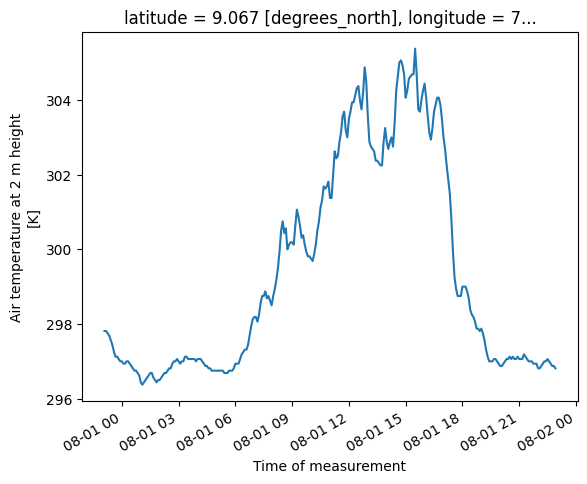

In [43]:
# Plot data
ds.temperature.plot()
plt.show()

## Via command line tools (CLI)

### Using ncdump


`ncdump` is a command line utility that comes with NCE utils to display the content of the file. However it is a bit "raw" and not user friendly.

In [44]:
!ncdump ABJ.nc | head -150

netcdf ABJ {
dimensions:
	time = UNLIMITED ; // (852 currently)
variables:
	string station_name ;
		station_name:standard_name = "platform_name" ;
		station_name:long_name = "station_name" ;
		station_name:cf_role = "timeseries_id" ;
	float latitude ;
		latitude:long_name = "station latitude" ;
		latitude:standard_name = "latitude" ;
		latitude:units = "degrees_north" ;
		latitude:_CoordinateAxisType = "Lat" ;
		latitude:axis = "Y" ;
	float longitude ;
		longitude:long_name = "station longitude" ;
		longitude:standard_name = "longitude" ;
		longitude:units = "degrees_east" ;
		longitude:_CoordinateAxisType = "Lon" ;
		longitude:axis = "X" ;
	float elevation ;
		elevation:long_name = "Elevation above mean seal level" ;
		elevation:standard_name = "height_above_mean_sea_level" ;
		elevation:_CoordinateAxisType = "Z" ;
		elevation:units = "m" ;
		elevation:axis = "Z" ;
	double crs ;
		crs:_FillValue = -999. ;
		crs:grid_mapping_name = "latitude_longitude" ;
		crs:longitude_of_prime_meridi

### With *ins-cat* (libinsitu)

[`ins-cat`](https://libinsitu.readthedocs.io/en/latest/cli/ins-cat.html) is a command line tool provided by libinsitu to read and dump NetCDF of timeseries into various formats.

In [45]:
# -s skip NaN values 
!ins-cat ABJ.nc -s | head -10

                    temperature
2008-07-31 23:05:00 297.8      
2008-07-31 23:10:00 297.8      
2008-07-31 23:15:00 297.8      
2008-07-31 23:20:00 297.7      
2008-07-31 23:25:00 297.6      
2008-07-31 23:30:00 297.4      
2008-07-31 23:35:00 297.2      
2008-07-31 23:40:00 297.1      
2008-07-31 23:45:00 297.1      
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [46]:
# As CSV / with header 
!ins-cat ABJ.nc  --type csv -hd | head -100

# id = CARNASRDA-ABJ
# title = Timeseries of CARNASRDA. Station : Abuja
# summary = Archive of solar radiation networks worldwide provided by the Webservice-Energy initiative supported by MINES Paris PSL. Files are provided as NetCDF file format with the support of a Thredds Data Server.
# keywords = meteorology, station, time, Earth Science > Atmosphere > Atmospheric Radiation > Incoming Solar Radiation, Earth Science > Atmosphere > Atmospheric Temperature > Surface Temperature > Air Temperature, Earth Science > Atmosphere > Atmospheric Pressure > Sea Level Pressure
# keywords_vocabulary = GCMD Science Keywords
# keywords_vocabulary_url = https://gcmd.earthdata.nasa.gov/static/kms/
# record = Basic measurements (global irradiance, direct irradiance, diffuse irradiance, air temperature, relative humidity, pressure)
# featureType = timeSeries
# cdm_data_type = timeSeries
# product_version = libinsitu unset (local)
# Conventions = CF-1.10 ACDD-1.3
# publisher_name = Lionel MENARD, Raphae

In [47]:
# Filter on single hour 
!ins-cat ABJ.nc -f 2008-08-01T22

                    temperature
2008-08-01 22:00:00 296.8      
2008-08-01 22:05:00 296.8      
2008-08-01 22:10:00 296.9      
2008-08-01 22:15:00 296.9      
2008-08-01 22:20:00 297.0      
2008-08-01 22:25:00 297.0      
2008-08-01 22:30:00 297.1      
2008-08-01 22:35:00 297.0      
2008-08-01 22:40:00 296.9      
2008-08-01 22:45:00 296.9      
2008-08-01 22:50:00 296.9      
2008-08-01 22:55:00 296.8      


In [48]:
# Show statistics
!ins-cat ABJ.nc -z

┏━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ column      ┃ count ┃ min    ┃ max    ┃ mean   ┃
┡━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ temperature │ 287   │ 296.38 │ 305.38 │ 299.33 │
└─────────────┴───────┴────────┴────────┴────────┘
